In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
import os
import keras
import numpy as np
import tensorflow as tf

## 1.Import and Prep df

---



In [ ]:
od.download('https://www.kaggle.com/datasets/hendryhb/batik-nusantara-batik-indonesia-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: annisakumaladewi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hendryhb/batik-nusantara-batik-indonesia-dataset


100%|██████████| 101M/101M [00:00<00:00, 1.37GB/s]

The block below inspects the dataset directory to confirm the presence of train/test splits and the number of class folders.

In [ ]:
directory_path = '/content/batik-nusantara-batik-indonesia-dataset/raw_batik_v2.1'

folders_list = []

for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)
    if os.path.isfile(item_path):
        folders_list.append(item)
    elif os.path.isdir(item_path):
        folders_list += [f'{item}:{len(os.listdir(item_path))}']

print(f'Folders: {folders_list}')

Folders: ['train:20', 'test:20']


In [ ]:
# Settings
IMG_SIZE = 224
BATCH_SIZE = 32 # train groups of 32 images at a time
SEED = 123

train_dir = "/content/batik-nusantara-batik-indonesia-dataset/raw_batik_v2.1/train"
test_dir  = "/content/batik-nusantara-batik-indonesia-dataset/raw_batik_v2.1/test"


#### Load datasets from test and train folders

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

Found 640 files belonging to 20 classes.
Found 160 files belonging to 20 classes.
Classes: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']
Number of classes: 20


In [ ]:
# Peek at one batch
images, labels = next(iter(train_ds))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (32, 20)


## 2. Normalization and Performance

---



In [ ]:
# Improve input scaling and pipeline performance
AUTOTUNE = tf.data.AUTOTUNE # finds the optimal no. of batches to prepare ahead of time

train_ds = train_ds.cache().prefetch(AUTOTUNE) # load the dataset into memory after the first pass
test_ds  = test_ds.cache().prefetch(AUTOTUNE) # prepare the next batchh while the current batch is training


Normalise pixel values

In [ ]:
# Data augmentation to help generalization on small datasets
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # flip image left-right
    tf.keras.layers.RandomRotation(0.1), # rotate image randomly up to 10%
    tf.keras.layers.RandomZoom(0.1), # zoom in/out slightly
], name="data_augmentation")

# Build a CNN model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # defining structure of model & expected input shape

x = data_augmentation(inputs)

# Normalize pixels from [0..255] to [0..1]
x = tf.keras.layers.Rescaling(1./255)(x)

Data Augmentation
* Df is small for deep learning
* meaning its bound to memorise exact images and may fail on new ones
* so we augment the data (without changing the label) to have variability, only in training
* that way the model learns general patterns instead of memorising specific images, which helps reduce overfitting on small datasets

Normalise pixels
* previously pixel was from 0 = black to 255 = bright
* I changed the range so that its 0 to 1
* my code essentially makes 0 -> 0, and 255 -> 1

### Convolution + Pooling layers

In [ ]:
# Convolution + Pooling blocks (feature extraction)

# Apply 16 different filters, each filter looks at 3x3 patch,
x = tf.keras.layers.Conv2D(16, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Turn the 2D feature grids into a single vector per image
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Helps reduce overfitting (randomly drops some signals during training)
x = tf.keras.layers.Dropout(0.3)(x)

# Final classifier
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)



Conv2D
* Runs three different convolutionol layers, one with 16 filters (learn basic patterns such as lines), and gradually increases to 64 filters (learn more complex patterns)
* kernel size = 3 represents size of filter, 3 x 3
* uses relu for simplicity, activation decides which neurons should be "activated" in the next layer

Max Pooling
* runs a 2 x 2 "window" which scans the feature maps (output of filtering), taking the highest values
* this essentially shrinks the image aka no of pixels, and reduce them to most relevant ones

Global Average Pooling
* turns a feature map into one number by averaging it -> reduces parameters and helping generalisation
* currently feature map is like a grid / an image-like thing, but a classifier (dense layers) wants a 1d list of numbers per image
* Global average pooling is the "bridge" from feature grids -> a feature vector

Dropout
* a regularisation method to reduce overfitting on a small dataset
* how it works: during *training* it randomly turns off about 30% of the values going forward (sets them to 0)
* this forces the model to not rely too much on one path/feature

Dense
* 2 dense layers
* a dense layer is when each neuron is connected to all the input neurons
* classification only happens in the final dense layer. the first does feature combination / reasoning (thinking) and the second does the classification (deciding).
* first dense layer:
  * takes 64 input numbers (from the last conv2d layers), has 64 neurons
  * each neuron:
    * looks at all 64 inputs
    * learns a combination of features
  * so each neurons represent combinations of learned image features

* second dense layer:
  * softmax layer, it does two things:
    * converts raw scores into probabilities (0 to 1)
    * makes all probabilities sum to 1




*The final model contains three convolutional blocks followed by global average pooling and two dense layers, totaling approximately 29k trainable parameters. Convolutional layers perform feature extraction, while dense layers handle classification.*

### Building the model, and model summary

In [ ]:
# Build the full model: inputs -> outputs
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,044 (113.45 KB)

 Trainable params: 29,044 (113.45 KB)

 Non-trainable params: 0 (0.00 B)

Compile, train and fit model

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.0468 - loss: 3.0060 - val_accuracy: 0.0500 - val_loss: 2.9919
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.0452 - loss: 2.9877 - val_accuracy: 0.0500 - val_loss: 2.9832
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.0541 - loss: 2.9818 - val_accuracy: 0.0688 - val_loss: 2.9718
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.0824 - loss: 2.9673 - val_accuracy: 0.0875 - val_loss: 2.9256
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.0734 - loss: 2.9229 - val_accuracy: 0.0938 - val_loss: 2.9104
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1033 - loss: 2.8940 - val_accuracy: 0.1000 - val_loss: 2.8973
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1359 - loss: 2.8403 - val_accuracy: 0.1312 - val_loss: 2.8383
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1373 - loss: 2.7888 - val_accuracy: 0.1562 - val_loss:

* Adam optimizer was used for efficient and stable training.
* Categorical crossentropy was used as the loss function for multi-class classification.

model.compile
* tells Keras how the model should learn
* defines how it updates weights (adam), how it measures error (cross entropy), how it reports performance (accuracy)
* adam - algorithm that updates the model's weights during training. it decides how big each update should be and in which direction.
* categorical crossentropy - how far the predicted probabilities are from the true class

early_stop
* this tells the model to stop training when the model stops improving on validation data
* it watches validation loss not training loss - which tells you if generalisation improves
* patience = 10; if validation loss doesnt improve for 10 epochs, stop training
* restore_best_weights=True ; after stopping, go back to the model state with the lowest validation loss
* validation loss: how wrong the model is on data it did not train on. opposite of training loss - error on training data

history = model.fit
* fitting the model - where learning actually happens
* epochs=50, maximum of 50 passes over training data, unless stopped by early_stop
* stored in history to plot curves

## Evaluation

### Calculating test loss and accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - accuracy: 0.2832 - loss: 2.3544
Test loss: 2.321315288543701
Test accuracy: 0.32499998807907104


Overall not a great performance yet
* 32.5% accuracy on a 20-class problem

### Plotting Training vs Validation Curves

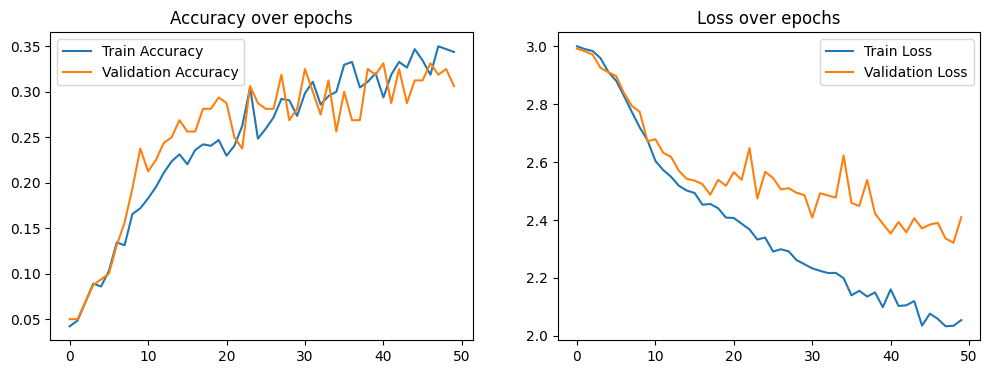

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over epochs")

plt.show()


Saving trained model

In [ ]:
model.save("batik_cnn_model.keras")

Making prediction on images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


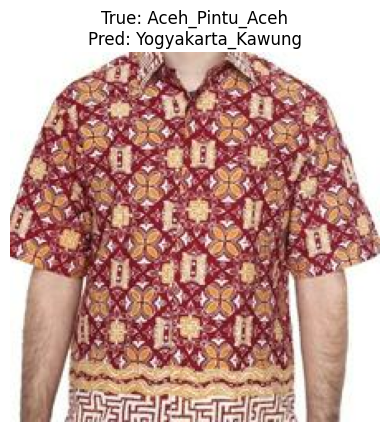

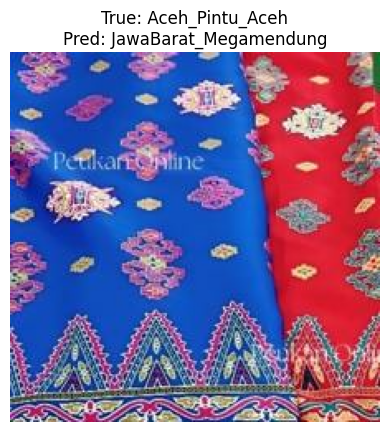

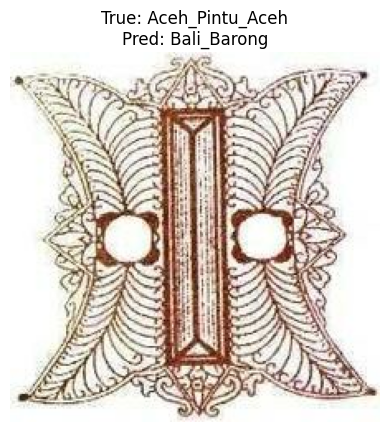

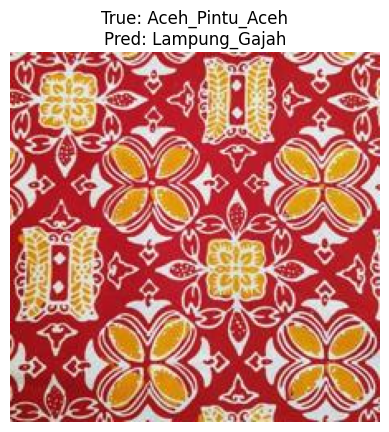

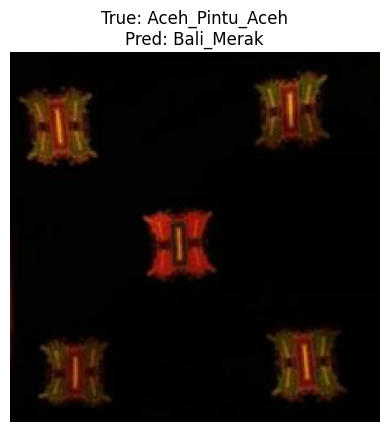

In [ ]:
# Take one batch from test data
images, labels = next(iter(test_ds))

predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels.numpy(), axis=1)

for i in range(5):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")
    plt.show()


### Confusion Matrix

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)

    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm


array([[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0,

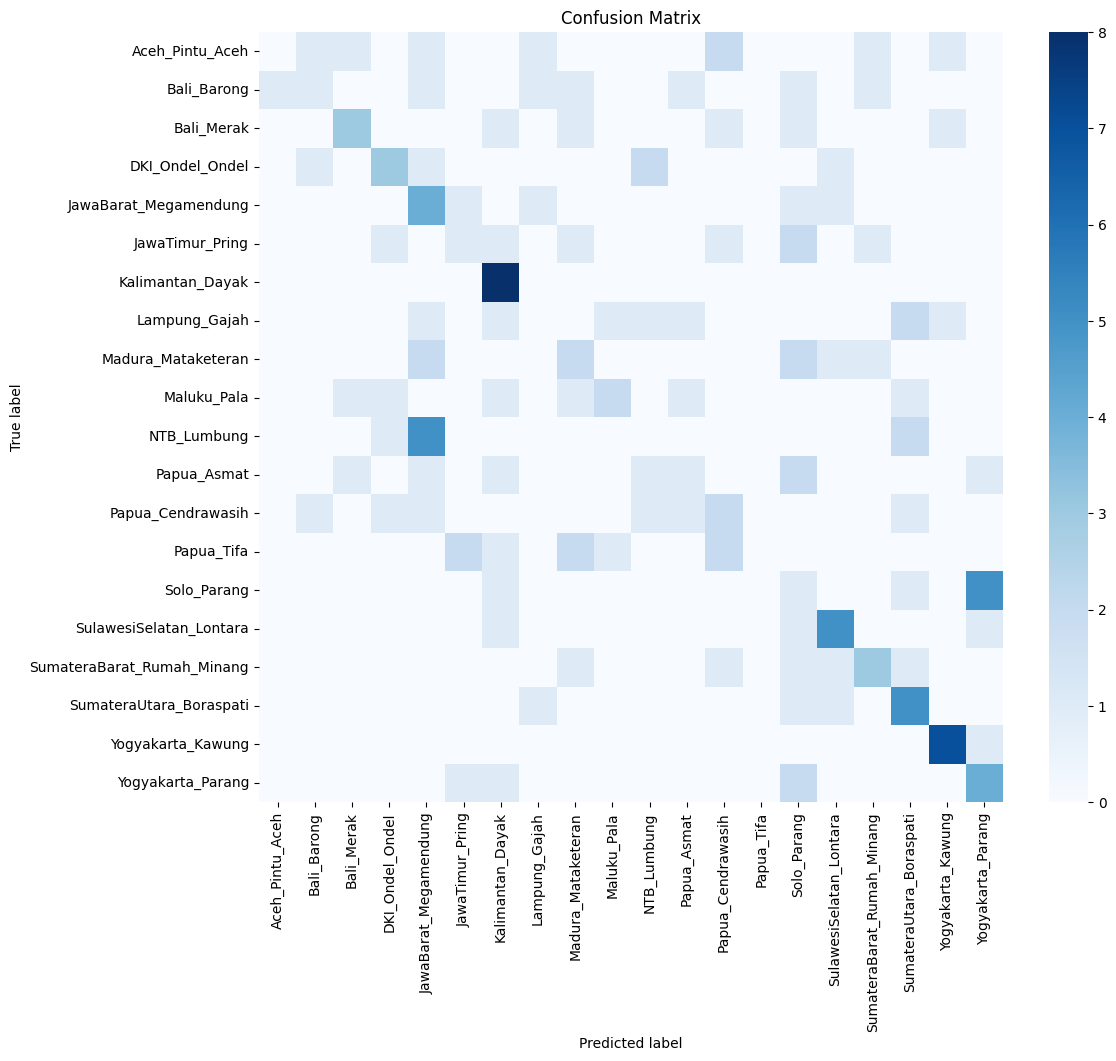

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
    fmt="d"
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()
